In [19]:
import pydicom
import os

In [20]:
# Le chemin relatif vers les DICOM
dicom_dir_path = "../data/dicom"

# On vérifie qu'on a bien ce dossier
if not os.path.exists(dicom_dir_path):
    raise ValueError(f"Ce chemin n'existe pas  : {dicom_dir_path}")

print(dicom_dir_path)

../data/dicom


In [22]:
from glob import glob

# On récupère tous les dicom du répertoire et on les stock dans une liste
dicom_list_path = glob(dicom_dir_path + "/*")

# On récupère le 1er dicom du dossier
dicom_file_path = dicom_list_path[0]
print(dicom_file_path)

# On ouvre le dicom avec pydicom
ds = pydicom.dcmread(dicom_file_path)

# On affiche les tags du dicom
print(ds)

# On affiche un tag 
print(f"Date de l'examen : {ds.StudyDate}")

../data/dicom\_.MR.ETUDES_CRANE_DY.2.1.2022.05.20.11.57.17.20.23254583.dcm
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 196
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.12.2.1107.5.8.15.132345.30000022052011571437000000011
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.12.2.1107.5.99.3.20080101
(0002, 0013) Implementation Version Name         SH: 'SIEMENS'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'ND', 'NORM', 'FM3_2', 'FIL']
(0008, 0012) Instance Creation Date              DA: '20210316'
(0008, 0013) Instance Creation Time              TM: '0

Il existe deux fonctions de Pydicom permettant d'obtenir l'image stockée dans le DICOM.
PixelData : cela nous retourne une longue chaine de caractère en bytes qu'il faudra traduire en nombre entier.
pixel_array : Cela nous retourne directement un tableau contenant les informations des pixels en nombre entier.

In [23]:
# On récupère l'image en bytes
pixel_data = ds.PixelData
# On affiche le type du tableau
print(type(pixel_data))
# On affiche les 100 premiers éléments de pixel_data
print(pixel_data[:100])

# On récupère l 'image en integer (entier)
pixel_array = ds.pixel_array
# On affiche le type du tableau
print(type(pixel_array))
# On affiche les 100 premiers éléments de pixel_array
print(pixel_array[:100])


<class 'bytes'>
b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
<class 'numpy.ndarray'>
[[ 0  0  0 ...  0  0  0]
 [ 0  3  4 ... 10  8 12]
 [ 0 10 13 ...  7 11  9]
 ...
 [ 0  4  3 ...  6  5  8]
 [ 0  2  3 ...  9  6  7]
 [ 0  2  3 ...  4  5  5]]


Il faut importer la librairie Matplotlib pour afficher l'image.
Il y a plusieurs façon d'afficher le tableau pixel_array. 
Dans un premier temps, voyons la manière la plus banale.

(288, 240)


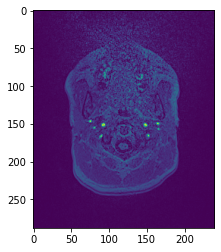

In [24]:
import matplotlib.pyplot as plt

# On afficher les dimensions de l'image
print(pixel_array.shape)

# On affiche l'image
plt.imshow(pixel_array)
plt.show()

L'image affichée utilse un gradient de couleur appelé "viridis". Cependant, les radiologues visualisent principalement leurs images en niveau de gris.
Il va donc falloir changer de gradient de couleurs.

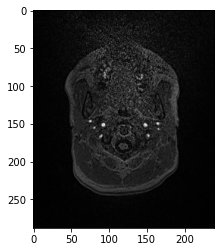

In [25]:
# On affiche l'image en niveau de gris
plt.imshow(pixel_array, cmap="gray")
plt.show()

Pas mal ! 
Lorsqu'on a sélectionné le DICOM, on a récupéré le 1er DICOM du dossier. Celui-ci correspond à une des premières images acquises par l'IRM.
Pour obtenir une image du cerveau, il va falloir récupérer un des DICOM se trouvant vers le milieu du répertoire de DICOM.

Nombre de dicom : 192


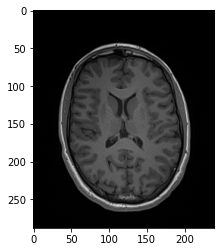

In [26]:
# On affiche le nombre de DICOM
print(f"Nombre de dicom : {len(dicom_list_path)}")

# On sélectionne l'indice du dicom qui nous intéresse
mid_dicom = 10
dicom_file_path = dicom_list_path[mid_dicom]

# On refait les mêmes manipulations que précédemment
ds = pydicom.dcmread(dicom_file_path)
pixel_array = ds.pixel_array
plt.imshow(pixel_array, cmap="gray")
plt.show()

Pour modfier un tag, rien de plus simple, il suffit juste de modifier un des éléments de notre variable "ds"

In [27]:
# On affiche le champ "Series Description"
print(ds.SeriesDescription)

# On modifie le champ "Series Description"
ds.SeriesDescription = "AX T2 FLAIR"

# On affiche le champ une fois modifié
print(ds.SeriesDescription)


AX T1 MPRAGE
AX T2 FLAIR


En utilisant ce principe, on va pouvoir modifier l'image du DICOM en manipulant "pxel_array"

In [28]:
# On récupère les coordonnées x et y qui correspondent au centre de l'image
center_x = pixel_array.shape[0] // 2
center_y = pixel_array.shape[1] // 2
# On définit la longueur/largeur de notre carré
demi_length = 10

# On récupère l'intensité maximale de l'image qui sera la couleur du carré
import numpy as np
max_value = np.max(pixel_array)

# On change l'intensité des pixels du centre de l'image avec la nouvelle valeur calculée
pixel_array[
    center_x - demi_length : center_x + demi_length, 
    center_y - demi_length : center_y + demi_length
    ] = max_value

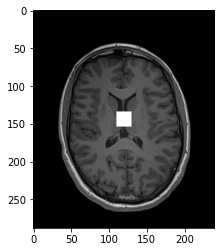

In [29]:
# On affiche le nouveau tableau modifié
plt.imshow(pixel_array, cmap="gray")
plt.show()

Pour sauvegarder cette nouvelle image, il va falloir définir un chemin pour notre DICOM

In [30]:
# On définit un chemin
new_dicom_path = "../data/dicom/nouveau_dicom.dcm"

# On utilise la fonction de Pydicom pour sauvegarder le dicom
ds.save_as(new_dicom_path)

Bravo ! Vous avez modifié et sauvegardé votre premier DICOM. Vérifiez dans votre dossier DICOM qu'il a bel et bien été crée.

In [31]:
# On supprime le DICOM crée pour la suite
if os.path.exists(new_dicom_path):
    os.remove(new_dicom_path)

Une fois MRIcron installé, un fichier dcm2niix.exe devrait se trouver dans le dossier "Resources". C'est ce fichier exécutable qui va nous permette de convertir un dossier de DICOM en fichier Nifti.

In [32]:
# On récupère le chemin vers l'exécutable dcm2niix
dcm2niix_path = "\"C:/Program Files/MRIcron/Resources/dcm2niix.exe\""

# Le chemin où on va sauvegarder les Nifti 
nifti_dir_path = "../data/nifti"

# La commande pour convertir un dossier de DICOM en un seul et unique Nifti
command = '\"' + dcm2niix_path + ' -f %p -z y -o ' +  '\"' + nifti_dir_path + '\" \"' + dicom_dir_path + '\"'

# On afficher la commande
print(command)

# Et on l'exécute
os.system(command)

""C:/Program Files/MRIcron/Resources/dcm2niix.exe" -f %p -z y -o "../data/nifti" "../data/dicom"


0

In [33]:
# Le chemin du fichier Nifti
nifti_path = "../data/nifti/AX_T1_MPRAGE.nii.gz"

# On vérifie qu'on a bien un fichier Nifti crée
if not os.path.exists(nifti_path):
    raise ValueError(f"Ce chemin n'existe pas  : {nifti_path}")

print(nifti_path)

../data/nifti/AX_T1_MPRAGE.nii.gz


In [34]:
import nibabel as nib

# On ouvre un Nifti avec Nibabel
nifti = nib.load(nifti_path)

# On affiche les metadonnées du Nifti
print(nifti)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (240, 288, 192)
affine: 
[[ 8.88878286e-01 -4.34391340e-03  0.00000000e+00 -1.06971313e+02]
 [ 4.34391340e-03  8.88878286e-01  0.00000000e+00 -1.19151947e+02]
 [ 0.00000000e+00  0.00000000e+00  9.00001526e-01 -6.65795441e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 54
dim             : [  3 240 288 192   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.         0.8888889  0.8888889  0.90000004 1.95       0.
 0.         0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
c

In [35]:
# On affiche quelques élements essentiels du Nifti
print(f"Dimension : {nifti.header['dim']}")
print(f"Affine : {nifti.affine}")
print(f"Taille du tableau : {nifti.shape}")
print(f"Données du tableau : {nifti.get_fdata()}")

Dimension : [  3 240 288 192   1   1   1   1]
Affine : [[ 8.88878286e-01 -4.34391340e-03  0.00000000e+00 -1.06971313e+02]
 [ 4.34391340e-03  8.88878286e-01  0.00000000e+00 -1.19151947e+02]
 [ 0.00000000e+00  0.00000000e+00  9.00001526e-01 -6.65795441e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Taille du tableau : (240, 288, 192)
Données du tableau : [[[ 3.  2.  3. ...  1.  2.  2.]
  [ 2.  2.  3. ...  1.  2.  1.]
  [ 1.  2.  3. ...  1.  2.  5.]
  ...
  [ 9.  7.  6. ...  1.  1.  1.]
  [12.  7.  6. ...  1.  0.  1.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[ 1.  3.  4. ...  1.  2.  1.]
  [ 2.  1.  3. ...  2.  3.  2.]
  [ 1.  1.  2. ...  1.  2.  4.]
  ...
  [11.  6.  7. ...  1.  1.  2.]
  [ 8.  5. 12. ...  1.  0.  1.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[ 1.  2.  3. ...  2.  2.  2.]
  [ 2.  1.  3. ...  2.  4.  1.]
  [ 2.  3.  2. ...  1.  2.  2.]
  ...
  [ 7.  9.  8. ...  0.  0.  1.]
  [10.  9. 16. ...  1.  1.  1.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 ...

 [[ 4.  2.  2

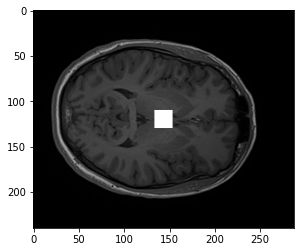

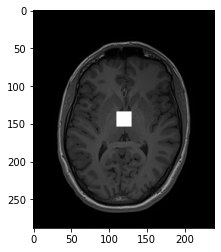

In [38]:
# On récupère le tableau 3D contenu dans le Nifti
data = nifti.get_fdata()

# On récupère les coordonnées x, y et z qui correspondent au centre de l'image
center_x = data.shape[0] // 2
center_y = data.shape[1] // 2
center_z = data.shape[2] // 2

# On définit la longueur/largeur de notre carré
demi_length = 10

# On récupère l'intensité maximale de l'image qui sera la couleur du carré
max_value = np.max(data)

# On change l'intensité des pixels du centre de l'image avec la nouvelle valeur calculée
data[
    center_x - demi_length : center_x + demi_length, 
    center_y - demi_length : center_y + demi_length,
    center_z - demi_length : center_z + demi_length
    ] = max_value

# On afficher une coupe en axial (3ème dimension)
plt.imshow(data[:, :, center_z], cmap="gray")
plt.show()

# Pour l'affichage dans matplotlib, il faut permuter les dimensions et parcourir x et y dans le sens inverse pour afficher parfaitement l'image
temp = np.rot90(data)

# On afficher une coupe en axial de notre image modifiée (toujours la 3ème dimension)
plt.imshow(temp[:, :, center_z], cmap="gray")
plt.show()

In [ ]:
# On crée un nouvel objet Nifti avec le tableau 3D et l'affine du Nifti original
nifti = nib.Nifti1Image(data, nifti.affine)

# On définit un nouveau chemin pour le Nifti qu'on va sauvegarder
new_nifti_path = "../data/nifti/NEW_AX_T1_MPRAGE.nii.gz"

# On sauvegarde le Nifti
nib.save(nifti, new_nifti_path)